# Near Surface Analysis
This looks at whether there is significant different between using the *2m* variables versus the lowest atmospheric level.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-05-03 15:04:26,448 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [24]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'temp_2m', 'rh_2m', 'sphum_2m', 'ps']        # only keep variables required to compute relative humidity and MSE
pressure_ft = 500
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    try:
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    except KeyError:
        var_keep.remove('cape')     # not all datasets have cape variable
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
pressure_ft_actual = float(ds[0].pfull[0])
pressure_low_level = float(ds[0].pfull[-1])

## Check relative humidity calculation
Compute *2m* relative humidity on a random day, and compare to the Isca value to see if calculation correct.

The left hand histogram shows that the actual relative humidity definition of water vapour partial pressure, $e$, divided by saturation partial pressure, $e_{sat}$, is almost exactly the same as the equation commonly used of the ratio between specific humidity, $q$, and saturation specific humidity, $q_{sat}$.

The central histogram shows that the manual computation of relative humidity generally matches the Isca output but sometimes overestimates it.
The right hand histogram shows that using the lowest level atmospheric pressure, $p_{low}$ rather than the surface pressure, $p_s$, in computing the saturation specific humidity gives a relative humidity increases the deviation from the Isca output.

Overall, it seems like the manual computation of relative humidity **matches the Isca output well but not exactly**.

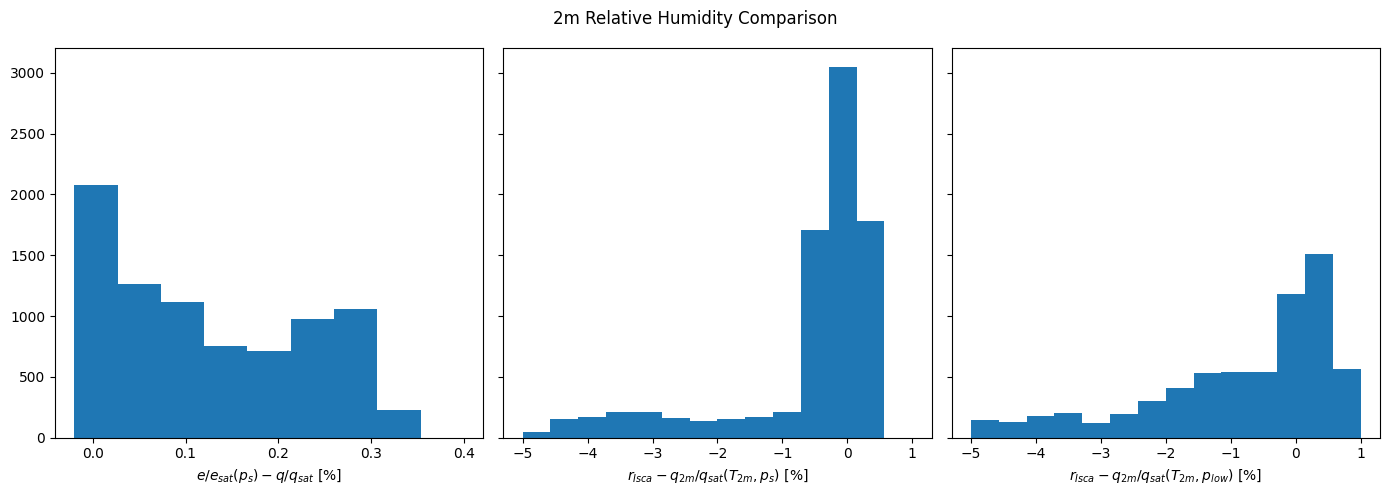

In [127]:
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

ds_single_day = ds[0].sel(time=np.random.randint(ds[0].time.max()), method='nearest',
                          drop=True).sel(pfull=pressure_low_level, method='nearest', drop=True)[
    ['temp_2m', 'rh_2m', 'sphum_2m', 'ps', 'temp', 'sphum']].load()
ds_single_day = ds_single_day.stack(lon_lat=("lat","lon"), create_index=False).chunk(dict(lon_lat=-1))
rh_manual_q = ds_single_day.sphum_2m / sphum_sat(ds_single_day.temp_2m, ds_single_day.ps) * 100
rh_manual_e = rh_from_sphum(ds_single_day.sphum_2m, ds_single_day.temp_2m, ds_single_day.ps)
rh_manual_q_low_pressure = ds_single_day.sphum_2m / sphum_sat(ds_single_day.temp_2m, pressure_low_level*100) * 100

rh_bins = np.linspace(-5, 1, 15)
fig, ax = plt.subplots(1,3, figsize=(14, 5), sharey=True)
ax[0].hist(rh_manual_e - rh_manual_q, bins=np.linspace(-0.02, 0.4, 10))
ax[0].set_xlabel('$e/e_{sat}(p_s) - q/q_{sat}$ [%]')
ax[1].hist(ds_single_day.rh_2m - rh_manual_q, bins=rh_bins)
ax[1].set_xlabel('$r_{Isca} - q_{2m}/q_{sat}(T_{2m}, p_s)$ [%]')
ax[2].hist(ds_single_day.rh_2m - rh_manual_q_low_pressure, bins=rh_bins)
ax[2].set_xlabel('$r_{Isca} - q_{2m}/q_{sat}(T_{2m}, p_{low})$ [%]')
fig.suptitle('2m Relative Humidity Comparison')
plt.tight_layout();

The plot below shows that relative humidity tends to be larger at the lowest level of the atmosphere compared to the *2m* value. This makes sense because the lowest level is above *2m* and as air rises up the dry adiabat, the temperature drops but the specific humidity remains the same so the saturation deficit decreases.

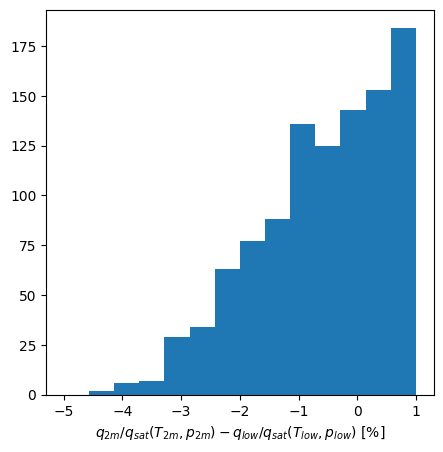

In [130]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
rh_manual_low = ds_single_day.sphum / sphum_sat(ds_single_day.temp, pressure_low_level*100) * 100
ax.hist(rh_manual_q - rh_manual_low, bins=rh_bins)
ax.set_xlabel('$q_{2m}/q_{sat}(T_{2m}, p_{2m}) - q_{low}/q_{sat}(T_{low}, p_{low})$ [%]');

## Get datasets
Get one dataset for summer for each $\kappa$, in a given latitude bin: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in January, February or March.

In [202]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# If true, will save figures to desktop
save_fig = False

# Chose whether to only consider summer days or consider all days
season = 'summer'
# season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        # all days not summer
        # ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_all += [ds_use.load()]
        if season == 'summer':
            # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
            ds_all[i] = ds_all[i].sel(lon_lat_time = ds_all[i].lon_lat_time[np.invert(np.isnan(ds_all[i].temp[-1]))].to_numpy())
        pbar.update(1)

100%|██████████| 2/2 [00:13<00:00,  6.79s/it]


In [203]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile, range_below=0, range_above=np.inf, use_var=None):
    if use_var is None:
        use_var = dataset.temp[-1]
    # Have quantile in range instead of above a given percentile
    # The default is still above a given percentile though
    quant_min = np.clip(percentile-range_below, 0, 100)
    quant_max = np.clip(percentile+range_above, 0, 100)
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh_min = use_var.quantile(quant_min/100, dim='lon_lat_time', keep_attrs=True)
    quantile_thresh_max = use_var.quantile(quant_max/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(np.logical_and(use_var > quantile_thresh_min, use_var <= quantile_thresh_max))[0]
    return quant_ind

# avoid 0 quantile as it gives weird results
quant_plot = np.arange(1, 100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

temp_low_mean = np.zeros(n_exp)
temp_2m_mean = np.zeros(n_exp)
sphum_low_mean = np.zeros(n_exp)
sphum_2m_mean = np.zeros(n_exp)
mse_low_mean = np.zeros(n_exp)
mse_2m_mean = np.zeros(n_exp)
mse_quant = np.zeros((n_exp, n_quant)) # surface value corresponding to the average obove a given percentile in temperature

for i in range(n_exp):
    temp_low_mean[i] = np.mean(ds_all[i].temp[-1])
    temp_2m_mean[i] = np.mean(ds_all[i].temp_2m)
    sphum_low_mean[i] = np.mean(ds_all[i].sphum[-1])
    sphum_2m_mean[i] = np.mean(ds_all[i].sphum_2m)
    mse_low_mean[i] = np.mean(moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1]))
    mse_2m_mean[i] = np.mean(moist_static_energy(ds_all[i].temp_2m, ds_all[i].sphum_2m, 2))

## High Percentile to Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

The scaling $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles, implying that the theory may be appropriate.

The dotted lines show the *2m* variables, but they are basically identical to the low level.

In [204]:
# quant is the actual quantile value rather than the average above a given quantile
temp_low_quant = np.zeros((n_exp, n_quant))
temp_2m_quant = np.zeros((n_exp, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_low_quant = np.zeros((n_exp, n_quant))
sphum_2m_quant = np.zeros((n_exp, n_quant))
# mse as function of mse quantile not temp quantile
mse_low_quant = np.zeros((n_exp, n_quant))
mse_2m_quant = np.zeros((n_exp, n_quant))
# rh using sphum_quant and temp_quant i.e. assuming sphum and temp quantiles are the same
# can't calculate 2m rh here as don't know what pressure to use in sphum_sat calc
rh_low_quant = np.zeros_like(temp_low_quant)

for i in range(n_exp):
        temp_low_quant[i] = ds_all[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        temp_2m_quant[i] = ds_all[i].temp_2m.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        sphum_low_quant[i] = ds_all[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        sphum_2m_quant[i] = ds_all[i].sphum_2m.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        mse = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
        mse_low_quant[i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        mse = moist_static_energy(ds_all[i].temp_2m, ds_all[i].sphum_2m, 2)
        mse_2m_quant[i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        rh_low_quant[i] = 100 * sphum_low_quant[i] / sphum_sat(temp_low_quant[i], pressure_low_level*100)

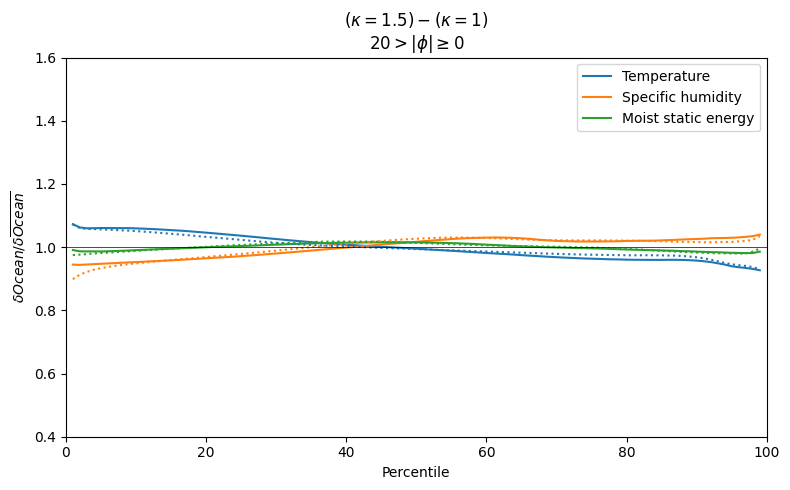

In [205]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,1, figsize=(8, 5))
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [var[1] - var[0] for var in [temp_low_mean, sphum_low_mean, mse_low_mean]]
for i, var in enumerate([temp_low_quant, sphum_low_quant, mse_low_quant]):
    ax.plot(quant_plot, (var[1]-var[0])/delta_var_mean[i], label=labels[i])
delta_var_mean = [var[1] - var[0] for var in [temp_2m_mean, sphum_2m_mean, mse_2m_mean]]
for i, var in enumerate([temp_2m_quant, sphum_2m_quant, mse_2m_quant]):
    ax.plot(quant_plot, (var[1]-var[0])/delta_var_mean[i], color=default_colors[i], linestyle=':')
ax.hlines(1,0,100, color='k', linewidth=0.5)
ax.legend()
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax.set_ylim(0.4,1.6)
ax.set_xlim(0, 100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda{str(tau_lw_ref).replace('.','_')}")

## Theory for $\delta T(p)$

### Form of MSE equation to start theory
From the above plot, we have $\delta h(p) = \delta \overline{h}$. Because this is an aquaplanet, higher temperatures are associated with higher moist static energies, as indicated by the $p^x$ vs $x$ plot.

Thus, we expect equation 10 in the paper: $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ should hold. In the plot below, we see that this is the case.

The red line shows the *2m* values, the change is greater but relative to the mean the change is the same, as is shown above.

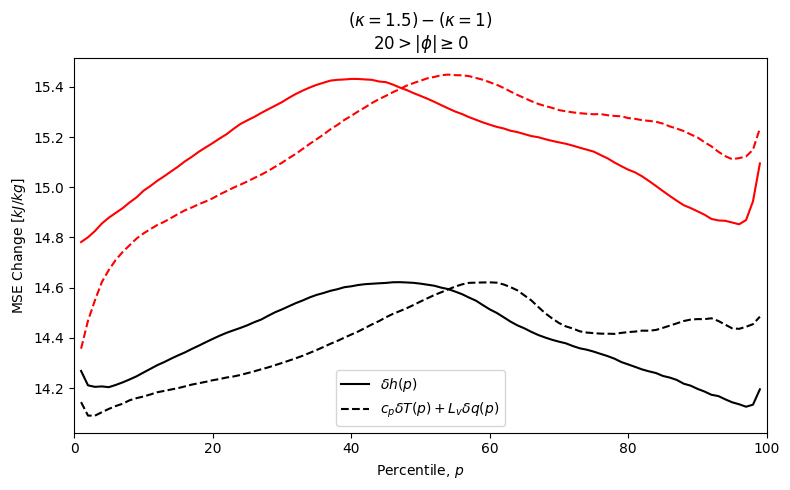

In [206]:
fig_delta_mse, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_low_quant[1]-mse_low_quant[0], label = '$\delta h(p)$', color='k')
ax.plot(quant_plot, (c_p * (temp_low_quant[1]-temp_low_quant[0]) + L_v * (sphum_low_quant[1]-sphum_low_quant[0]))/1000,
        label='$c_p \delta T(p) + L_v \delta q(p)$', color='k', linestyle='--')
ax.plot(quant_plot, mse_2m_quant[1]-mse_2m_quant[0], color='r')
ax.plot(quant_plot, (c_p * (temp_2m_quant[1]-temp_2m_quant[0]) + L_v * (sphum_2m_quant[1]-sphum_2m_quant[0]))/1000,
        color='r', linestyle='--')
ax.legend()
ax.set_xlabel('Percentile, $p$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.set_xlim(0,100)
plt.tight_layout()

## Percentile vs average around a percentile
When computing $h_{FT}^*(p)$, rather than just considering a single day for each percentile, we took the average of all days around a given percentile e.g. for $x=90$, we consider average over all days with a temperature percentile between $89.5 < x \leq 90.5$. We do a sanity check below to make sure this doesn't change the temperature and relative humidity terms shown above too much.

In the plots below, $p$ refers to the percentile for that quantity e.g. $h(p)$ is the percentile $p$ of MSE. $x$ refers to the average over all days between $x-0.5$ and $x+0.5$ percentile of a given quantity e.g. $h(x_T=90)$ is the MSE averaged over all days with temperature between the 89.5 and 90.5 percentile.

In [207]:
# Get values averaged around a temperature/sphum percentile, rather than exactly on it.
rh_low_quant_temp_percentile = np.zeros_like(temp_low_quant)
rh_2m_quant_temp_percentile = np.zeros_like(temp_low_quant)
rh_2m_isca_quant_temp_percentile = np.zeros_like(temp_low_quant)
rh_low_quant_sphum_percentile = np.zeros_like(temp_low_quant)
rh_2m_quant_sphum_percentile = np.zeros_like(temp_low_quant)
rh_2m_isca_quant_sphum_percentile = np.zeros_like(temp_low_quant)

with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            # Take percentile to be temperature percentile
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5)
            rh_low_quant_temp_percentile[i, j] = ds_all[i].sphum[-1, use_ind].mean() / sphum_sat(ds_all[i].temp[-1, use_ind].mean(),
                                                                                                 pressure_low_level*100)
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5, ds_all[i].temp_2m)
            rh_2m_quant_temp_percentile[i, j] = ds_all[i].sphum_2m[use_ind].mean() / sphum_sat(ds_all[i].temp_2m[use_ind].mean(),
                                                                                     ds_all[i].ps[use_ind].mean())
            rh_2m_isca_quant_temp_percentile[i, j] = ds_all[i].rh_2m[use_ind].mean()
            # Take percentile to be sphum percentile
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5, ds_all[i].sphum[-1])
            rh_low_quant_sphum_percentile[i, j] = ds_all[i].sphum[-1, use_ind].mean() / sphum_sat(ds_all[i].temp[-1, use_ind].mean(),
                                                                                                 pressure_low_level*100)
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5, ds_all[i].sphum_2m)
            rh_2m_quant_sphum_percentile[i, j] = ds_all[i].sphum_2m[use_ind].mean() / sphum_sat(ds_all[i].temp_2m[use_ind].mean(),
                                                                                     ds_all[i].ps[use_ind].mean())
            rh_2m_isca_quant_sphum_percentile[i, j] = ds_all[i].rh_2m[use_ind].mean()
            pbar.update(1)

100%|██████████| 198/198 [00:19<00:00, 10.14it/s]


Below I plot three versions of relative humidity.
* In black, is the specific humidity on the specific humidity percentile days divided by the saturated specific humidity on the temperature percentile days. This hybrid version doesn't make sense or reflect into any physically meaningful quantity, but it is the definition that I used in the above theory.
* In blue is the relative humidity averaged over the temperature percentile days, and we see a clear decrease in relative humidity for the hottesst days.
* In orange is the relative humidity averaged over the specific humidity percentile days, and we see a clear increase in relative humidity as $x_q$ increases.

The dotted lines indicate the *2m* value rather than the lowest level value. There is no dotted black line because there is no obvious pressure value to use in computing the saturation specific humidity.

We see that the *2m* relative humidity is larger than the low level atmosphere specific humidity. This quite suprising as you expect air to follow the dry adiabat between the levels, thus conserving specific humidity. But the temperature and thus the saturation deficit decrease as you rise, hence you would expect the relative humidity to increase with altitude.
The difference between simulations, shown in the bottom plot, don't really differ much between the two altitudes.

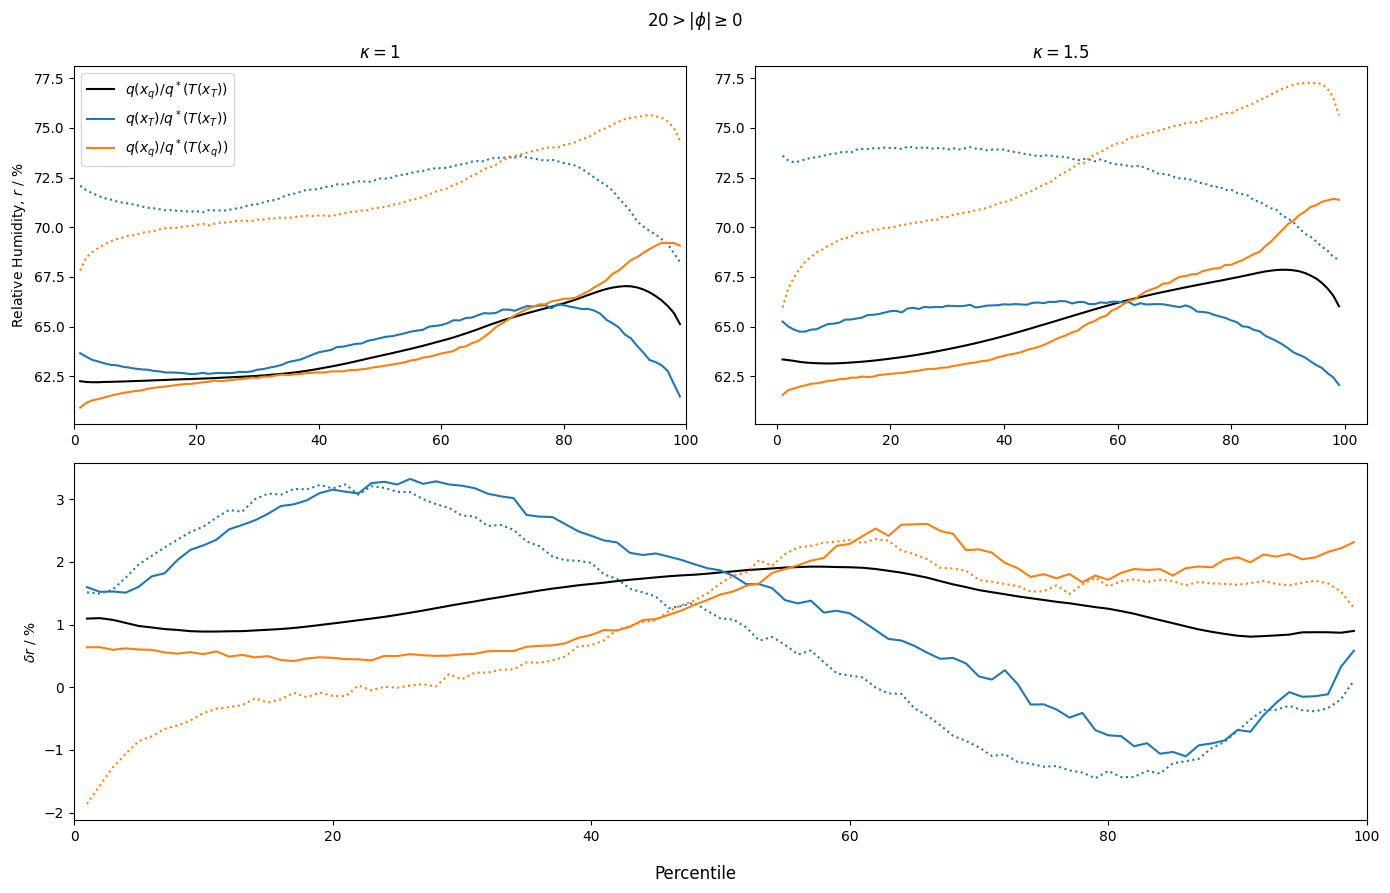

In [208]:
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax1.sharey(ax2)
ax1.sharex(ax1)
ax3.sharex(ax1)
ax = [ax1, ax2, ax3]
for i in range(n_exp):
    ax[i].plot(quant_plot, rh_low_quant[i], color='k',
               label='$q(x_q)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, 100*rh_low_quant_temp_percentile[i], color=default_colors[0],
               label='$q(x_T)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, 100*rh_2m_quant_temp_percentile[i], color=default_colors[0], linestyle=':')
    ax[i].plot(quant_plot, 100*rh_low_quant_sphum_percentile[i], color=default_colors[1],
               label='$q(x_q)/q^*(T(x_q))$')
    ax[i].plot(quant_plot, 100*rh_2m_quant_sphum_percentile[i], color=default_colors[1], linestyle=':')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax[-1].plot(quant_plot, rh_low_quant[1]-rh_low_quant[0], color='k')
ax[-1].plot(quant_plot, 100*(rh_low_quant_temp_percentile[1]-rh_low_quant_temp_percentile[0]), color=default_colors[0])
ax[-1].plot(quant_plot, 100*(rh_2m_quant_temp_percentile[1]-rh_2m_quant_temp_percentile[0]), color=default_colors[0], linestyle=':')
ax[-1].plot(quant_plot, 100*(rh_low_quant_sphum_percentile[1]-rh_low_quant_sphum_percentile[0]), color=default_colors[1])
ax[-1].plot(quant_plot, 100*(rh_2m_quant_sphum_percentile[1]-rh_2m_quant_sphum_percentile[0]), color=default_colors[1], linestyle=':')
ax[0].legend()
ax[0].set_ylabel('Relative Humidity, $r$ / %')
ax[2].set_ylabel('$\delta r$ / %')
ax[0].set_xlim(0,100)
fig.supxlabel('Percentile')
fig.suptitle(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout();

The plot below just confirms the changes in the Isca relative humidity are similar to the manually computed one.

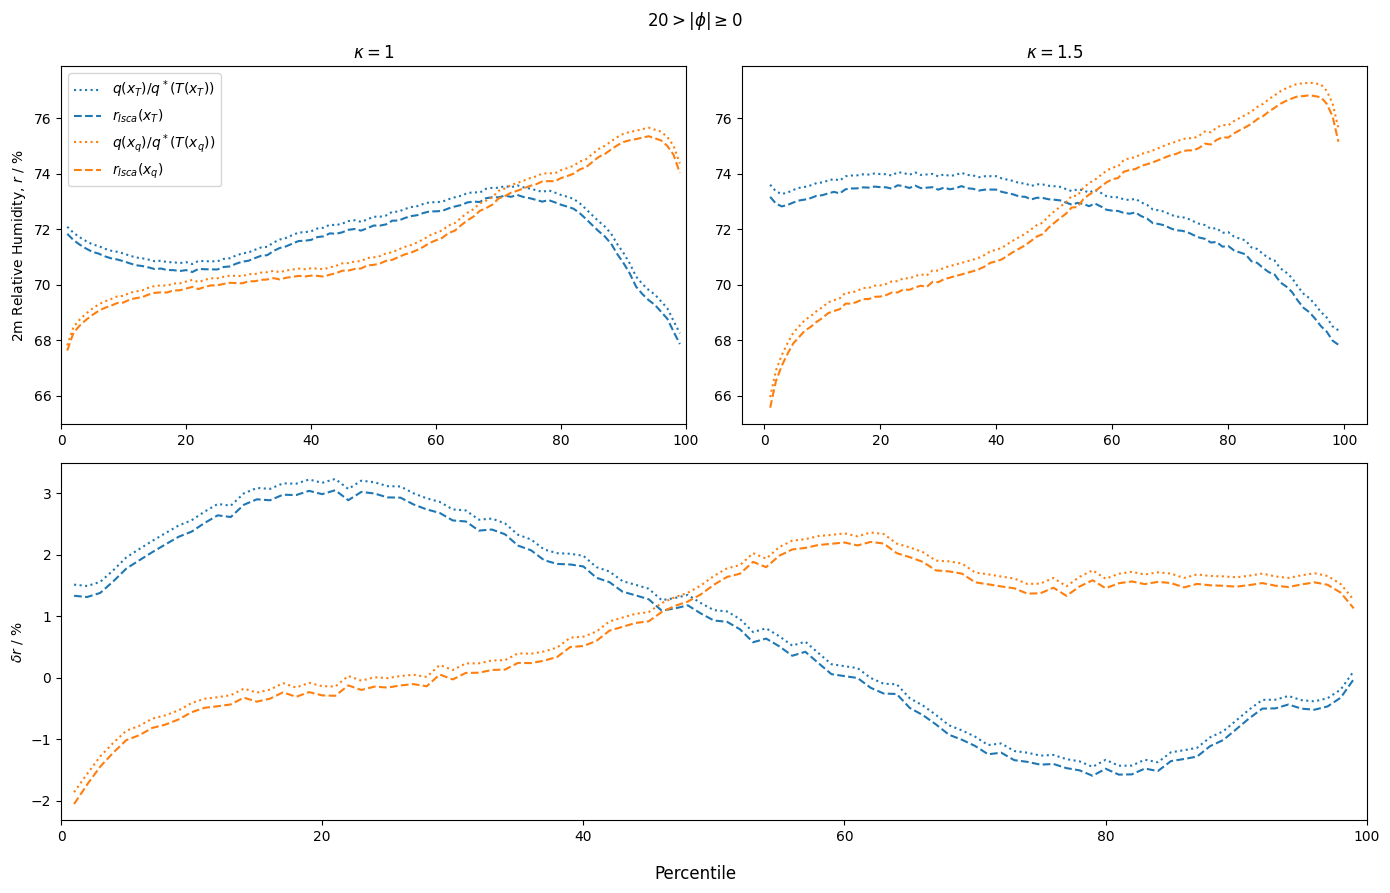

In [209]:
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax1.sharey(ax2)
ax1.sharex(ax1)
ax3.sharex(ax1)
ax = [ax1, ax2, ax3]
for i in range(n_exp):
    ax[i].plot(quant_plot, 100*rh_2m_quant_temp_percentile[i], color=default_colors[0], linestyle=':', label='$q(x_T)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, rh_2m_isca_quant_temp_percentile[i], color=default_colors[0],
               label='$r_{Isca}(x_T)$', linestyle='--')
    ax[i].plot(quant_plot, 100*rh_2m_quant_sphum_percentile[i], color=default_colors[1], linestyle=':', label='$q(x_q)/q^*(T(x_q))$')
    ax[i].plot(quant_plot, rh_2m_isca_quant_sphum_percentile[i], color=default_colors[1],
               label='$r_{Isca}(x_q)$', linestyle='--')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax[-1].plot(quant_plot, 100*(rh_2m_quant_temp_percentile[1]-rh_2m_quant_temp_percentile[0]), color=default_colors[0], linestyle=':')
ax[-1].plot(quant_plot, rh_2m_isca_quant_temp_percentile[1]-rh_2m_isca_quant_temp_percentile[0],
            color=default_colors[0], linestyle='--')
ax[-1].plot(quant_plot, 100*(rh_2m_quant_sphum_percentile[1]-rh_2m_quant_sphum_percentile[0]), color=default_colors[1], linestyle=':')
ax[-1].plot(quant_plot, rh_2m_isca_quant_sphum_percentile[1]-rh_2m_isca_quant_sphum_percentile[0],
            color=default_colors[1], linestyle='--')
ax[0].legend()
ax[0].set_ylabel('2m Relative Humidity, $r$ / %')
ax[2].set_ylabel('$\delta r$ / %')
ax[0].set_xlim(0,100)
fig.supxlabel('Percentile')
fig.suptitle(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout();